In [1]:
#Authors: Eli Gumble, Peter Brommer, Harry Brown
#Initialisation
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import simps
from scipy import signal as sg
from scipy.interpolate import RectBivariateSpline as ReBiSpline 
from numpy import ma
from matplotlib import colors, ticker, cm
from random import choice
import scipy.ndimage.filters as filters
import scipy.ndimage.morphology as morphology
import timeit
import math
from PIL import Image

import matplotlib.image as image2
%matplotlib inline

In [2]:
# Read grids from image
#im = Image.open("belgiumtest.bmp")
#Base = np.array(im)

im = image2.imread("belgiumtestorig2x.bmp")
Base = np.array(im)


In [3]:

#print(Base[0,0,1])
#Base = np.where(Base[:,:,0]==43, 0, Base)
#Base

#                        [[r, g, r2, g2]...]     description
landcoverlist = np.array([[22,95,0,0],           # water
                          [209,209,150,150],       # bare floor
                          [139,139,175,175],     # artificial surface
                          [221,5,0,0],           # building
                          #[0,0,0,0],            # herbaceous cover in rotation throughout year
                          [234,255,80,175],       # herbaceous cover (grass)
                          [40,202,60,80],        # tall hardwood > 3m
                          [185,233,40,80],       # short hardwood < 3m
                          [1,47,65,80],          # tall softwood > 3m
                          #[0,0,0,0],            # short softwood < 3m
                          [43,80,0,0]])          # boundary
                                        
#len(landcoverlist)

for k in range (len(landcoverlist)):
    for i in range(len(Base)):             #vertical pixels
        for j in range(len(Base[0])):      #horizontal pixels
            if Base[i][j][0] == landcoverlist[k,0] and Base[i][j][1] == landcoverlist[k,1]:
                Base[i][j] = [landcoverlist[k,2],landcoverlist[k,3],0,255]


In [4]:
Base[:,:,2] = 0 #set all pixel B values to 0

Base[:,:,3] = 255 #set all of the 4th rgb element to 255 because things might break otherwise

In [5]:
# Define internal quantities and variables
scale = 1./2. #m per pixel
Nx = Base[:,0,0].size #N appears to be resolution
Ny = Base[0,:,0].size
xmin=-scale*0.5*(Nx-1)
xmax=scale*0.5*(Nx-1)
ymin=-scale*0.5*(Ny-1)
ymax=scale*0.5*(Ny-1)
x = np.linspace(xmin, xmax, Nx) # This is defining the axes and full space
y = np.linspace(ymin, ymax, Ny)
Y, X= np.meshgrid(y, x)
TrailPotential = np.zeros((Nx,Ny))
DestinationPotential=np.zeros((Nx,Ny))
Weight=np.zeros((Nx,Ny))  # Create gradient to sit on Nx, Ny
intens=np.zeros((Nx,Ny))
q_alpha=np.zeros((Nx,Ny))
expdist=np.zeros((2*Nx-1,2*Ny-1))
dest=np.zeros((2))
start=np.zeros((2))
grad=np.zeros((2,Nx,Ny))
vel=np.asarray([0.,0.])
pos=np.asarray([0.,0.])
stalledpos = [] # empty container for stalled positions of walkers
stalledposrounded = []

#desdirx=ReBiSpline(x,y,grad[0,:,:],s=2)
#desdiry=ReBiSpline(x,y,grad[1,:,:],s=2)
intens[:]=0.

#print(route)
#parameters
t_track=50. # Track decay time - after 50 walkers ignore a trail, it decays by 1/e
wlkr_range = 10000
dt=0.1  # dt per time step, continuous markings every dt metres
dvel=1. # desired walker velocity in m/s
tau=5.
isigma=1./2. # trail potential
trailpotweight = 0.0035 # weighting of trail potential over destination potential, started as 0.003, increasing this increases number of stalls
conv_thresh=10.e-4
precision=1.**2 #distance to target.
eps=0.025 #random motion contribution, same for all


In [6]:
##Set up map
#Create blank arrays for map 
z = np.zeros((Nx,Ny))
g_max=np.zeros((Nx,Ny))
g_nat=np.zeros((Nx,Ny))

g_nat=np.maximum(np.ones_like(g_nat),np.float64(Base[:,:,0]))
g_max=np.maximum(np.ones_like(g_max),np.float64(Base[:,:,1]))
z=g_nat

track_labels=Base[:,:,2]

numpoints=np.max(track_labels)

point=np.zeros((numpoints,2))

for i in range(0,Nx):
    for j in range(0,Ny):
        if (track_labels[i,j]>0):
            point[track_labels[i,j]-1]=np.array([i,j])
print (point)

# Trails (start and end point) For current Map, coordinates in metres, centre of image = (0,0)

# single possible path
# route=np.array([[24.,-9.75],[-24.,9.75]]),

# big field with tennis court parking lot and hospital, near rue cottrel
ptA = [-40.,-240.]      # tennis court near middle
ptB = [-250.,-200.]     # tennis court near skatepark
ptC = [-350., 25.]     # parking lot entrance
ptD = [-350., 80.]      # parking lot bus stop
ptE = [-70., 230.]      # east road pedestrian entrance
ptF = [200., 200.]      # hospital bus stop
ptG = [250., 100.]      # hospital side path
ptH = [350., -100.]     # dirt car park
ptI = [210., -140.]     # west side entrance

#route=np.array([[pointE,pointI],
#                [pointI,pointE]])

route=np.array([[ptA,ptD],
                [ptA,ptE],
                [ptA,ptF],
                [ptA,ptG],
                [ptD,ptA],
                [ptD,ptF],
                [ptD,ptG],
                [ptD,ptH],
                [ptD,ptI],
                [ptF,ptA],
                [ptF,ptB],
                [ptF,ptD],
                [ptF,ptI],
                [ptI,ptB],
                [ptI,ptD],
                [ptI,ptE],
                [ptI,ptG],
                [ptE,ptH]])

# small field by apartment with 4 entrances 
#posA = [-5., -17.]
#posB = [-25., -17.]
#posC = [-25., 8.]
#posD = [40., 10.]

# acceptable routes = A/B to C, A/C to D and vice versa, 8 total routes
#route=np.array([[posA,posC],
#                 [posB,posC],
#                 [posC,posA],
#                 [posC,posD],
#                 [posA,posC],
#                 [posC,posD],
#                 [posD,posA],
#                 [posD,posC],
#                 ])

 
# route=np.array([[[-2.5,14.],[24.,-9.75]]])


# commented out for single path
# route=np.array([[[-2.5,14.],[24.,-9.75]],
#                 [[-2.5,14.],[24.,2.5]],
#                 [[-2.5,14.],[-24.,9.75]],
#                 [[24.,-9.75],[-2.75,14.]],
#                 [[24.,-9.75],[-24.,9.75]],
#                 [[24.,2.5],[-2.75,14.]],
#                 [[24.,2.5],[-24.,9.75]],
#                 [[-24.,10.],[-2.75,14.]],
#                 [[-24.,10.],[24.,-9.75]],
#                 [[-24.,10.],[24.,2.5]]])


[]


In [7]:
#Setup weight matrix, here trapezoid rule.
Weight[:,:]=1
Weight[1:-1,:]=2
Weight[:,1:-1]=2
Weight[1:-1,1:-1]=4
Weight*=0.25*((x[-1]-x[0])/(Nx-1))*((y[-1]-y[0])/(Ny-1))
#0.25*((x[-1]-x[0])/(N-1))*((y[-1]-y[0])/(N-1))
#np.exp(-np.sqrt((x[:,None]-x[N/2])**2+(y[None,:]-y[N/2])**2))*z[:,:]

In [8]:
# Setup distance matrix
for xi in range(1,Nx+1):
    for yi in range(1,Ny+1):
        
        expdist[xi-1,yi-1]=np.exp(-isigma*np.sqrt((x[Nx-xi]-xmin)**2+(y[Ny-yi]-ymin)**2))
        expdist[-xi,-yi]  = expdist[xi-1,yi-1]
        expdist[-xi,yi-1] = expdist[xi-1,yi-1]
        expdist[xi-1,-yi] = expdist[xi-1,yi-1]
        
# find index range > conv_thresh
subexpdist=expdist[(expdist>conv_thresh).any(1)]
subexpdist=subexpdist[:, np.any(subexpdist>conv_thresh, axis=0)]
#subexpdist=subexpdist[:,np.any(subexpdist>conv_thresh, axis=0)]
#expdist[subexpdist]=0.
subexpdist.shape
#expdist
#subexpdist


(55, 55)

In [9]:
def calc_tr_new():
    TrailPotential[:,:]=sg.convolve2d(z[:,:]*Weight[:,:],subexpdist[:,:],mode="same")  # 2D convilution

In [10]:
timeit.timeit(calc_tr_new,number=1)

22.211812300000005

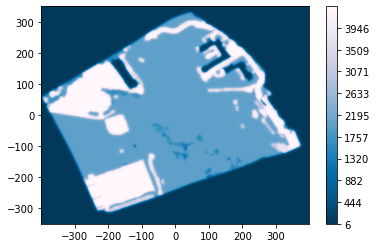

In [11]:
# Defines a Plot to show the smoothing of the supplied map to represent the respective potentials of the ground, the larger
# the potentials, the more attractive the ground is to the walker

cs = plt.contourf(X, Y, TrailPotential, levels=np.linspace(TrailPotential.min(),TrailPotential.max(),1000),cmap='PuBu_r')
cbar = plt.colorbar()

#plt.scatter(track[0:wlkr_range-1,0],track[0:wlkr_range-1,1])
plt.show()

In [12]:
#set up walker
def set_up_walker(route_id):
    global vel,pos,track,intens,dest,start,route
    #start
    start=np.array(route[route_id,0,:]) # commented for simplicity
    # start = np.array([24.,-9.75])  # temporary one route
    # dest = np.array([-24.,9.75])  # temporary one route
    # dest=(random.choice(ends))
    dest=np.array(route[route_id,1,:]) # commented for simplicity
    vel=np.array([0.,0.])
    pos=np.array(start)
    #print (pos)
    track=np.zeros((wlkr_range,2))
    #track[0,:]=pos[:]

In [13]:
#Calculate gradients eq 19
#Trail gradient
def setup_potentials():
    global grad,desdirx,desdiry,dest,trailpotweight
    grad=trailpotweight*np.array(np.gradient(TrailPotential))
    #grad=0.002*np.array(np.gradient(TrailPotential)) ORIGINAL
    
    #print (dest)
    #Destination potential
    DestinationPotential=-np.sqrt((dest[0]-x[:,None])**2+(dest[1]-y[None,:])**2)
    #Combine gradients
    grad+=np.array(np.gradient(DestinationPotential)[:])
    #Normalise
    #grad[:,:,:]/=(np.sqrt(grad[0,:,:]**2+grad[1,:,:]**2))
    desdirx=ReBiSpline(x,y,grad[0,:,:],s=2) # gradeint plus magnitude, Spline approximation over a rectangular mesh
    desdiry=ReBiSpline(x,y,grad[1,:,:],s=2) 
    #plot()
    #print(grad)

In [14]:
# #Plot the direction
# scgrad=np.arctan2(grad[1],grad[0])
# levels = np.linspace(-np.pi, np.pi, 360)
# cs = plt.contourf(X, Y,scgrad, levels=levels,cmap='hsv')

# cbar = plt.colorbar()
# # ERROR # plt.scatter(track[0:wlkr_range-1,0],track[0:wlkr_range-1,1])
# #plt.scatter(start, dest)
# print(start)
# print(dest)
# plt.show()

In [36]:
def stalledposregioncounter(newpos,stalledpos3):
    nearest = 5
    newposrounded = {"x":round(newpos[0]/nearest)*nearest,"y":round(newpos[1]/nearest)*nearest,"count":1}
    
    for existingpos in stalledpos3:
        if existingpos["x"] == newposrounded["x"] and existingpos["y"] == newposrounded["y"]:
            existingpos["count"]+=1
            return stalledpos3
    stalledpos3.append(newposrounded)
    return stalledpos3

In [16]:
def calc_path():
    global pos,vel,intens,track,dest,dvel,tau,stalledpos
    
    i=0
    hist=10
    samp=10
    avpos=np.zeros((2,hist))
    #Setup While loop to run until either the walker reaches the destination or the walker has passed 'wlkr_range' number of movement cycles to 
    #attempt to get there
    while (np.dot(pos-dest,pos-dest)>precision and i<wlkr_range):
    #set the postiion of the walker on its first then subsequent cycles
        
        #conditional logic saying to update the average position of the walker every 10 iterations
        #if (i%samp==0): avpos[:,(i%hist)//samp]=pos[:] #ORIGINAL
        if (i%samp==0): avpos[:,(i%(hist*samp))//samp]=pos[:]
            
        #print((i%hist)//samp)
        #print(avpos)
        
        gradmagnitude=max(0.0001,np.sqrt(desdirx(pos[0],pos[1])**2+desdiry(pos[0],pos[1])**2))
        xi=np.array(np.random.normal(0,1,2))
        # Equation 6 in Helbing, differential in position, eliminised velocity decay components
        # gradmagnitude makes sure it is normalised, desdir not normalised
        pos[0]+= dt *(dvel * desdirx(pos[0],pos[1])/gradmagnitude +np.sqrt(2.*eps/tau)*xi[0])  # x-position vector component 
        pos[1]+= dt *(dvel * desdiry(pos[0],pos[1])/gradmagnitude +np.sqrt(2.*eps/tau)*xi[1])  # y-position vector component
        
#        posGrad = math.degree(math.atan(pos[0]/pos[1]) # future position
        curDir = math.atan(desdiry(pos[0],pos[1])/desdirx(pos[0],pos[1]))
#         print(posGrad)
        # print(curDir)
        # pos+=dt*vel
        
        #vel[0]+=-1/tau*vel[0] + (dvel/tau)*desdirx(pos[0],pos[1])/gradmagnitude+np.sqrt(2.*eps/tau)*xi[0]   # Eqiation 5 in Helbing, differential in velocity
        #vel[1]+=-1/tau*vel[1] + (dvel/tau)*desdiry(pos[0],pos[1])/gradmagnitude+np.sqrt(2.*eps/tau)*xi[1]
        
        #Set the current position of the walker into the trakc array for the current iteration
        track[i,:]=pos[:]

#        if math.isnan(pos[1])==1: 
#                print ("NaN error ",pos,vel, dest)
#                break

        intens[int((pos[0]-xmin)*(Nx-1)/(xmax-xmin)),int((pos[1]-ymin)*(Ny-1)/(ymax-ymin))]+=1.
        i+=1
        if (i%(hist*samp)==0):
            meanpos=np.mean(avpos,axis=1)
            if (np.dot(pos-meanpos,pos-meanpos)<precision): 
                print ("Stalled progress ",pos,meanpos,vel, dest)
                stalledpos.append(meanpos) # store positions where walkers are stalled
                stalledposrounded = stalledposregioncounter(meanpos, stalledpos) # store ROUNDED positions of walker stalls and count occurence in rounded position
                break
    if (i==wlkr_range): print ("Missed goal ",dest,pos)           
    return i    
#stopping condition   

In [17]:
# Calculate Q_alpha (strength of markings) eq 15
def update_ground():
    global q_alpha,intens,z,g_max,t_track,g_nat
    q_alpha=intens*(1.-z/g_max)
    # Time evolution of ground potential
    #zdiff=(1./t_track)*(g_nat-z)+q_alpha
    z+=(1./t_track)*(g_nat-z)+q_alpha
    #cs = plt.contourf(X, Y, zdiff, cmap=cm.PuBu_r)
    #cbar = plt.colorbar()
    #plt.show
    #z[140:160,45:75]

In [18]:
def plot_path():
    plt.contourf(X, Y, z, levels=np.linspace(z.min(),z.max(),1000),cmap='PuBu_r')
    plt.colorbar()
    #plt.scatter(track[0:wlkr_range-1,0],track[0:wlkr_range-1,1],1)
    plt.show(block=False)

In [33]:
def plot_path2():
    global stalledpos
    markercolour = np.array([[1,0,0]])

    plt.contourf(X, Y, z, levels=np.linspace(z.min(),z.max(),1000),cmap='PuBu_r')
    
    stalledposarray = np.array(stalledpos)
    plt.scatter(stalledposarray[0:-1,0],stalledposarray[0:-1,1],1.,markercolour)
    plt.show(block=False)

In [ ]:
def plot_path3():
    global stalledposrounded
    markercolour = np.array([[1,0,0]])

    plt.contourf(X, Y, z, levels=np.linspace(z.min(),z.max(),1000),cmap='PuBu_r')
    
    for i in stalledpos:
        stalledposrounded.append([i["x"],i["y"]])

    stalledposarray = np.array(stalledposrounded)
    plt.scatter(stalledposarray[0:-1,0],stalledposarray[0:-1,1],1.,markercolour)
    plt.show(block=False)

In [21]:
tau = 5.

In [22]:
print(len(route))

18


In [23]:
iterations = 1
walkersperiteration = len(route)

for i in range(0,iterations):
    calc_tr_new()
    intens[:]=0.
    for j in range(0,walkersperiteration):
        #set_up_walker(np.random.randint(0,len(route)))
        set_up_walker(j)
        setup_potentials()
        #calc_path()
        print(i, start," -> ", dest, pos, calc_path())
    update_ground()
    #plot_path()

Stalled progress  [ -76.06024054 -127.09085199] [ -75.81218825 -127.70373406] [0. 0.] [-350.   80.]
0 [ -40. -240.]  ->  [-350.   80.] [ -76.06024054 -127.09085199] 1300
Stalled progress  [ -72.34684084 -127.05307023] [ -72.34433185 -127.00540605] [0. 0.] [-70. 230.]
0 [ -40. -240.]  ->  [-70. 230.] [ -72.34684084 -127.05307023] 1300
Stalled progress  [232.59667207  95.609258  ] [232.58832844  95.58017476] [0. 0.] [200. 200.]
0 [ -40. -240.]  ->  [200. 200.] [232.59667207  95.609258  ] 4900
0 [ -40. -240.]  ->  [250. 100.] [249.54184093  99.21880796] 4515
Stalled progress  [-350.98492779   67.89779228] [-350.9204214   67.9224307] [0. 0.] [ -40. -240.]
0 [-350.   80.]  ->  [ -40. -240.] [-350.98492779   67.89779228] 300
Stalled progress  [132.14026781 194.84384848] [132.0549695  194.72115876] [0. 0.] [200. 200.]
0 [-350.   80.]  ->  [200. 200.] [132.14026781 194.84384848] 5500
Stalled progress  [-95.57664844  79.96772084] [-95.63164104  79.89519538] [0. 0.] [250. 100.]
0 [-350.   80.]  

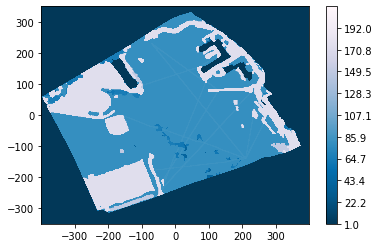

In [24]:

plot_path()

In [25]:
for i in range(0,Nx):
    for j in range(0,Ny):
        if (np.isnan(z[i,j])):
            print (i,j,g_max[i,j],Base[i,j,0])

In [26]:
def detect_local_maxima(arr):
    # https://stackoverflow.com/questions/3684484/peak-detection-in-a-2d-array/3689710#3689710
    """
    Takes an array and detects the troughs using the local maximum filter.
    Returns a boolean mask of the troughs (i.e. 1 when
    the pixel's value is the neighborhood maximum, 0 otherwise)
    """
    # define an connected neighborhood
    # http://www.scipy.org/doc/api_docs/SciPy.ndimage.morphology.html#generate_binary_structure
    neighborhood = morphology.generate_binary_structure(len(arr.shape),2)
    # apply the local minimum filter; all locations of minimum value 
    # in their neighborhood are set to 1
    # http://www.scipy.org/doc/api_docs/SciPy.ndimage.filters.html#minimum_filter
    local_max = (filters.maximum_filter(arr, footprint=neighborhood)==arr)
    # local_min is a mask that contains the peaks we are 
    # looking for, but also the background.
    # In order to isolate the peaks we must remove the background from the mask.
    # 
    # we create the mask of the background
    background = (arr==0)
    # 
    # a little technicality: we must erode the background in order to 
    # successfully subtract it from local_min, otherwise a line will 
    # appear along the background border (artifact of the local minimum filter)
    # http://www.scipy.org/doc/api_docs/SciPy.ndimage.morphology.html#binary_erosion
    eroded_background = morphology.binary_erosion(
        background, structure=neighborhood, border_value=1)
    # 
    # we obtain the final mask, containing only peaks, 
    # by removing the background from the local_min mask
    detected_maxima = local_max ^ eroded_background
    return np.where(detected_maxima) 

In [27]:
def plot_potentials():
    global dest
    TotPot = np.zeros((Nx,Ny))
    TotPot =- np.sqrt((dest[0]-x[:,None])**2+(dest[1]-y[None,:])**2)
    TotPot += 0.003*TrailPotential
    maxima=detect_local_maxima(TotPot)
    cs = plt.contourf(X, Y, TotPot, levels=np.linspace(TotPot.min(),TotPot.max(),1000),cmap='PuBu_r')
    cbar = plt.colorbar()
    print(maxima)
    plt.scatter(x[maxima[0]],y[maxima[1]])
    plt.scatter(track[0:wlkr_range-1,0],track[0:wlkr_range-1,1],1)
    plt.show
    # commit test

(array([ 410,  518,  604,  608,  657,  659,  663,  670,  670,  701,  715,
        716,  842,  979, 1003, 1015, 1031, 1032, 1042, 1061, 1113, 1126,
       1135, 1143, 1154, 1159, 1167, 1360, 1499], dtype=int64), array([ 770,  605,  847,  853,  257,  392,  372,  227,  433,  282,  213,
        207, 1254, 1170, 1068, 1078, 1182, 1089, 1219, 1083, 1025, 1043,
       1048, 1054, 1061, 1064, 1070,  832,  500], dtype=int64))


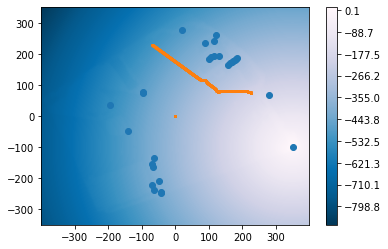

In [28]:
plot_potentials()

[-70. 230.]
[ 350. -100.]


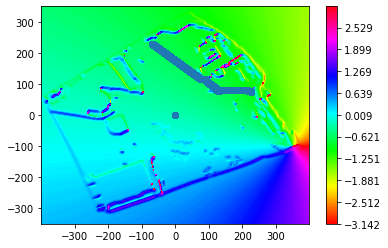

In [29]:
#Plot the direction
scgrad=np.arctan2(grad[1],grad[0])
levels = np.linspace(-np.pi, np.pi, 360)
cs = plt.contourf(X, Y,scgrad, levels=levels,cmap='hsv')

cbar = plt.colorbar()
plt.scatter(track[0:wlkr_range-1,0],track[0:wlkr_range-1,1])
#plt.scatter(start, dest)
print(start)
print(dest)
plt.show()


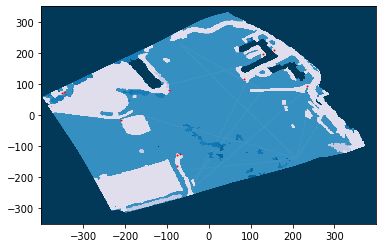

Number of walkers = 18
Walker success rate = 33.33333333333333 %


In [38]:
plot_path2()
numberofwalkers = iterations*walkersperiteration
successrate = 100-(100*len(stalledpos))/numberofwalkers
print(str("Number of walkers = ")+str(numberofwalkers))
print(str('Walker success rate = ')+str(successrate)+str(' %'))

In [ ]:
plot_path3()

In [ ]:
#Integrate z, trapezoid rule eq 20
# def calc_tr():
#    global xi,yi,TrailPotential,expdist,z,Weight,Nx,Ny
#    for xi in range(0,Nx): 
#        for yi in range(0,Ny):
#            TrailPotential[xi,yi]=np.sum(expdist[Nx-1-xi:2*Nx-1-xi,Ny-1-yi:2*Ny-1-yi]*z[:,:]*Weight[:,:])